Import Section

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

Call Samples

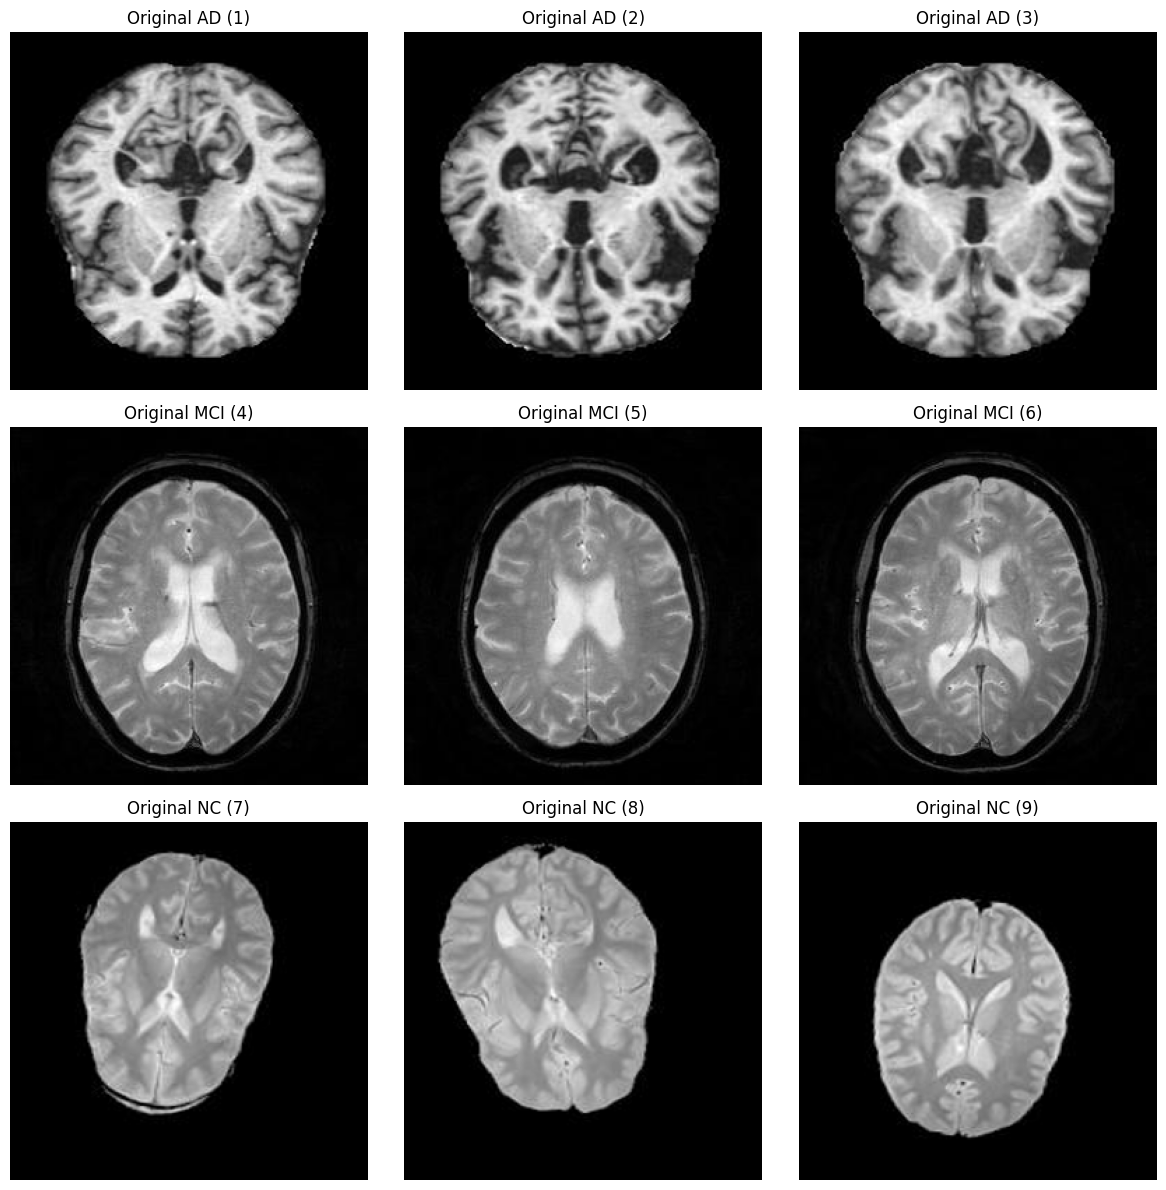

In [ ]:
# Define dataset path
images = []
labels = ["AD", "AD", "AD", "MCI", "MCI", "MCI", "NC", "NC", "NC"]
folder_path = "C://Users//lenovo//Desktop//محمد عبدالفتاح//DIP Project//Project on git//2-Midterm//Alzheimers_ADNI//Random Samples for IP"
for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = Image.open(image_path)
        if img.mode != 'L':
            img = img.convert('L')
        img = img.resize((256, 256))
        images.append(img)

plt.figure(figsize=(12, 12)) 
for i in range(min(9, len(images))): 
    plt.subplot(3, 3, i+1) 
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Original {labels[i]} ({i+1})")
    plt.axis('off') 

plt.tight_layout() 
plt.show()
images = np.array(images)

Apply Noises

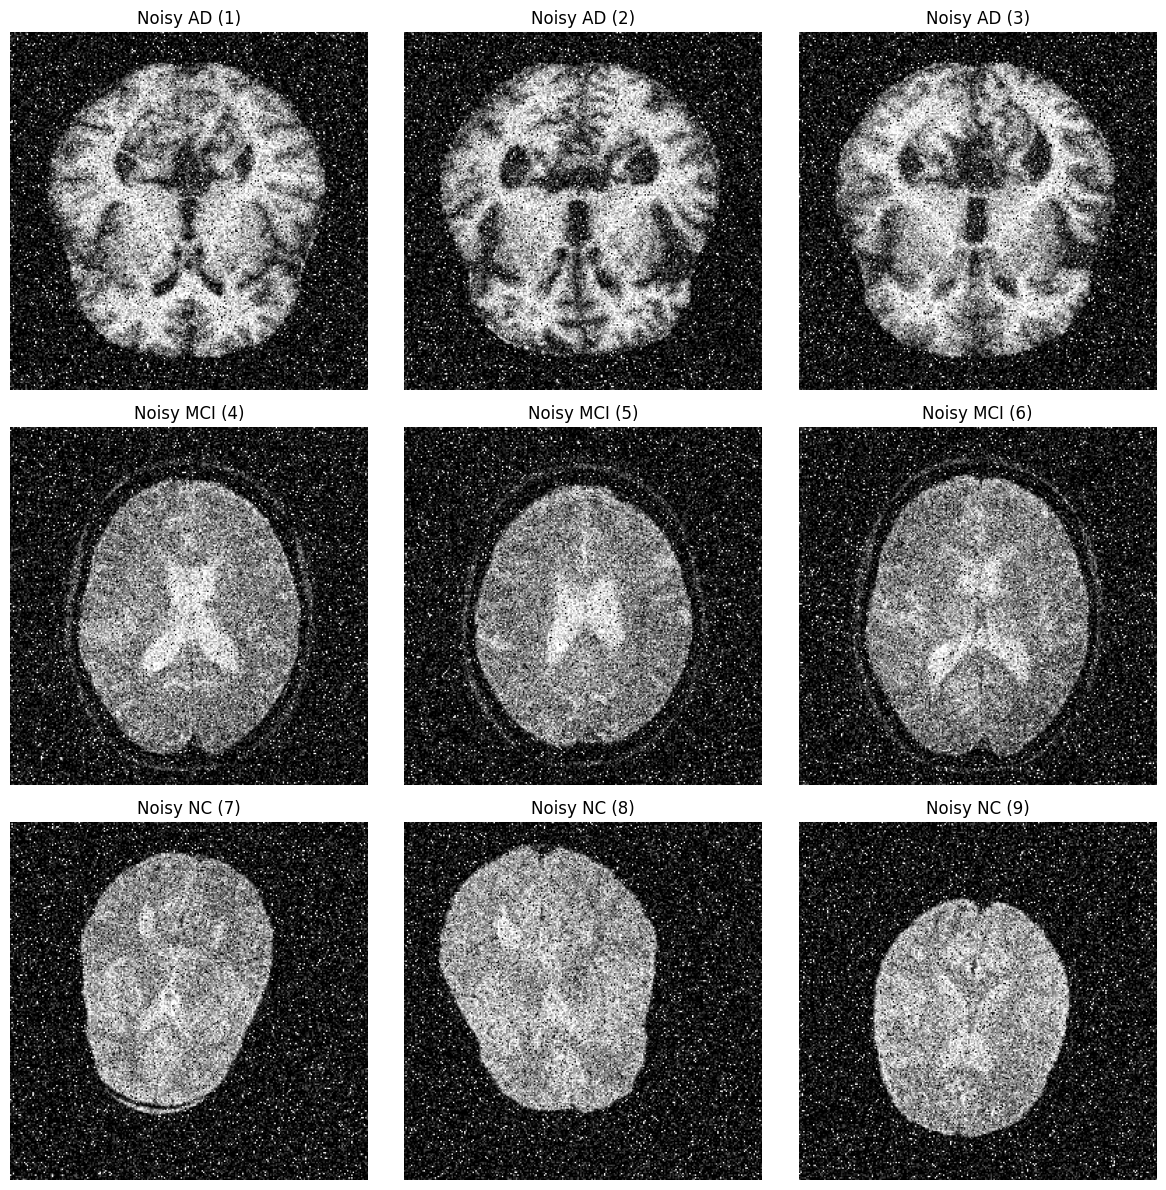

In [78]:
# Add Gaussian Noise
def add_gaussian_noise(images, mean=0, std=50):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape).astype(np.float32)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, 0, 255)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

# Add Salt-and-Pepper Noise
def add_salt_and_pepper_noise(images, amount=0.05):
    noisy_images = []
    for img in images:
        noisy_img = img.copy()
        num_salt = np.ceil(amount * img.size * 0.5)
        num_pepper = np.ceil(amount * img.size * 0.5)

        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
        noisy_img[coords[0], coords[1]] = 255

        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
        noisy_img[coords[0], coords[1]] = 0

        noisy_images.append(noisy_img)
    return np.array(noisy_images)

# Generate Noisy Images
gaussian_noisy_images = add_gaussian_noise(images)
salt_pepper_noisy__gaussian_images = add_salt_and_pepper_noise(gaussian_noisy_images)

#Display Noisy images
plt.figure(figsize=(12, 12)) 
for i in range(min(9, len(images))): 
    plt.subplot(3, 3, i+1) 
    plt.imshow(salt_pepper_noisy__gaussian_images[i], cmap='gray')
    plt.title(f"Noisy {labels[i]} ({i+1})")
    plt.axis('off') 

plt.tight_layout() 
plt.show()

Image enhancement Section

1- Apply individual filters

In [79]:
def apply_bilateral_filter(images):
    filtered_images = []
    for img in images:
        filtered_img = cv2.bilateralFilter(img.astype(np.uint8), d=9, sigmaColor=75, sigmaSpace=75)
        filtered_images.append(filtered_img)
    return np.array(filtered_images)

def apply_median_filter(images):
    filtered_images = []
    for img in images:
        filtered_img = cv2.medianBlur(img.astype(np.uint8), ksize=5)
        filtered_images.append(filtered_img)
    return np.array(filtered_images)

def apply_gaussian_filter(images):
    filtered_images = []
    for img in images:
        filtered_img = cv2.GaussianBlur(img.astype(np.uint8), (5, 5), 0)
        filtered_images.append(filtered_img)
    return np.array(filtered_images)

# Apply filters to noisy images
bilateral_filtered_images = apply_bilateral_filter(salt_pepper_noisy__gaussian_images)
median_filtered_images = apply_median_filter(salt_pepper_noisy__gaussian_images)
gaussian_filtered_images = apply_gaussian_filter(salt_pepper_noisy__gaussian_images)

# Evaluate performance
def evaluate_performance(original, filtered):
    psnr_values = [psnr(original[i], filtered[i], data_range=255) for i in range(len(original))]
    ssim_values = [
        ssim(original[i], filtered[i], data_range=255) for i in range(len(original))
    ]
    return np.mean(psnr_values), np.mean(ssim_values)

# Evaluate for each filter
bilateral_psnr, bilateral_ssim = evaluate_performance(images, bilateral_filtered_images)
median_psnr, median_ssim = evaluate_performance(images, median_filtered_images)
gaussian_psnr, gaussian_ssim = evaluate_performance(images, gaussian_filtered_images)

# Print results
print(f"Bilateral Filter - PSNR: {bilateral_psnr:.2f}, SSIM: {bilateral_ssim:.2f}")
print(f"Median Filter - PSNR: {median_psnr:.2f}, SSIM: {median_ssim:.2f}")
print(f"Gaussian Filter - PSNR: {gaussian_psnr:.2f}, SSIM: {gaussian_ssim:.2f}")

Bilateral Filter - PSNR: 17.87, SSIM: 0.22
Median Filter - PSNR: 25.47, SSIM: 0.48
Gaussian Filter - PSNR: 20.45, SSIM: 0.31


2- Apply selected IP steps

In [85]:
enhanced_Image = apply_median_filter(salt_pepper_noisy__gaussian_images)
enhanced_Image = apply_bilateral_filter(enhanced_Image)
enhanced_Image = apply_gaussian_filter(enhanced_Image)
#Evaluate and print Result
enhanced_psnr, enhanced_ssim = evaluate_performance(images, enhanced_Image)
print(f"enhanced_Image - PSNR: {enhanced_psnr:.2f}, SSIM: {enhanced_ssim:.2f}")

enhanced_Image - PSNR: 25.79, SSIM: 0.51


In [86]:
#Histogram equalization:
def apply_histogram_equalization(images):
    equalized_images = []
    for img in images:
        # Ensure the image is grayscale
        if len(img.shape) == 2:
            equalized_img = cv2.equalizeHist(img.astype(np.uint8))
            equalized_images.append(equalized_img)
        else:
            print("Image is not grayscale, skipping histogram equalization.")
    return equalized_images


equalized_images = apply_histogram_equalization(enhanced_Image)

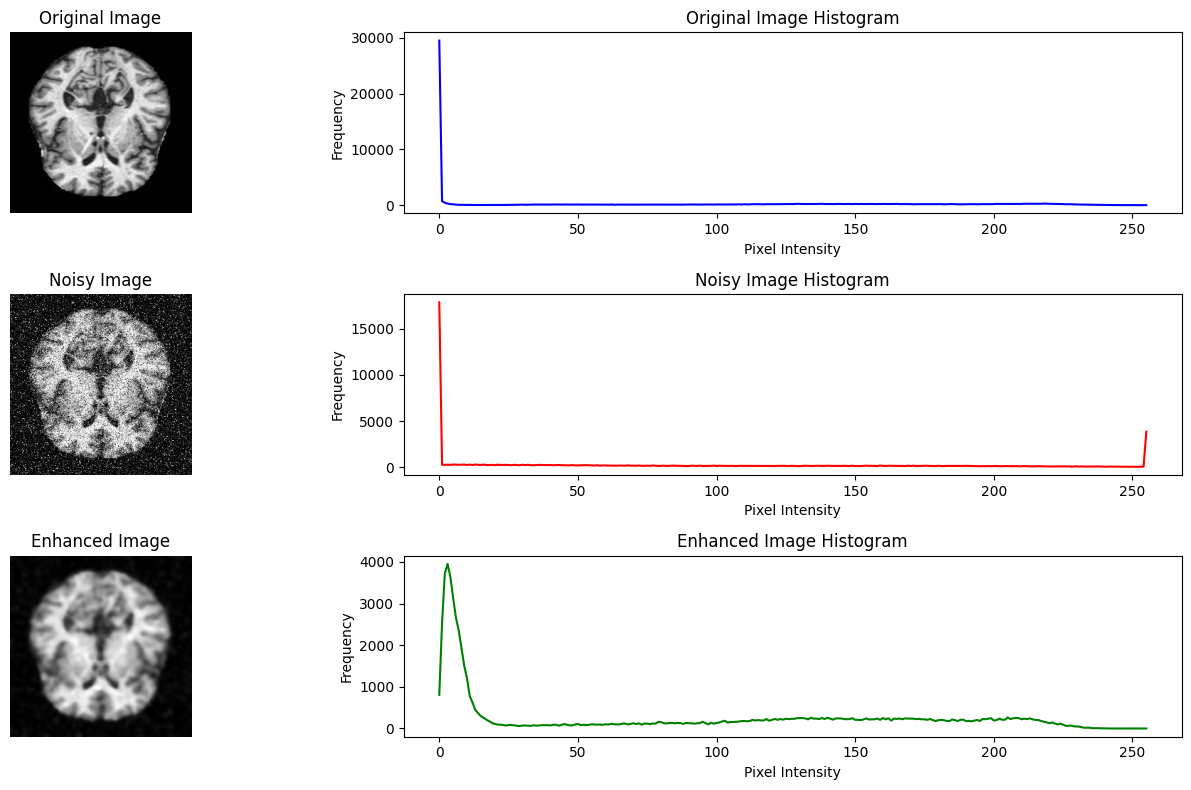

In [88]:
#Display histogram for origin, noise, and enhanced

def plot_histograms_with_noise(original_img, noisy_img, equalized_img):
    # Calculate histograms
    original_hist = cv2.calcHist([original_img], [0], None, [256], [0, 256])
    noisy_hist = cv2.calcHist([noisy_img], [0], None, [256], [0, 256])
    equalized_hist = cv2.calcHist([equalized_img], [0], None, [256], [0, 256])
    # Plot original image and histogram
    plt.figure(figsize=(15, 8))
    plt.subplot(3, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(3, 2, 2)
    plt.plot(original_hist, color='blue')
    plt.title("Original Image Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    # Plot noisy image and histogram
    plt.subplot(3, 2, 3)
    plt.imshow(noisy_img, cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    plt.subplot(3, 2, 4)
    plt.plot(noisy_hist, color='red')
    plt.title("Noisy Image Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    # Plot equalized image and histogram
    plt.subplot(3, 2, 5)
    plt.imshow(equalized_img, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')
    plt.subplot(3, 2, 6)
    plt.plot(equalized_hist, color='green')
    plt.title("Enhanced Image Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# original
original_image = images[0]

# noisy
noisy_image = salt_pepper_noisy__gaussian_images[0]

#enhanced
enhanced_image = enhanced_Image[0]

# Plot histograms
plot_histograms_with_noise(original_image, noisy_image, enhanced_image)

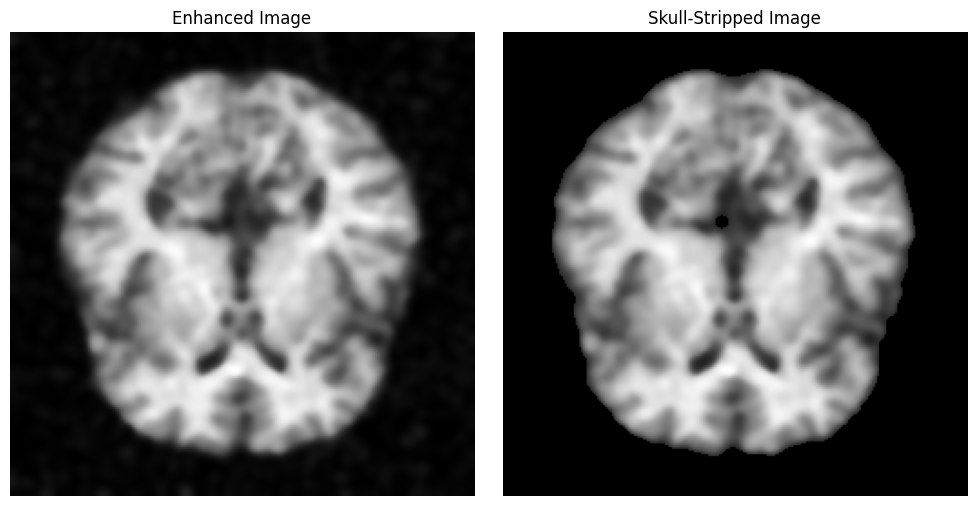

In [91]:
def skull_stripping(image):
    # Step 1: Apply binary thresholding
    _, binary_mask = cv2.threshold(image, 40, 255, cv2.THRESH_BINARY)
    # Step 2: Perform morphological operations to remove small regions
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    # Step 3: Find largest connected component (brain region)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Ignore background label 0
    # Step 4: Create a mask for the largest component
    brain_mask = (labels == largest_label).astype(np.uint8) * 255
    # Step 5: Mask the original image to retain only the brain region
    skull_stripped_image = cv2.bitwise_and(image, image, mask=brain_mask)
    
    return skull_stripped_image

# Apply skull stripping
skull_stripped_image = skull_stripping(enhanced_Image[0])


# Display original and skull-stripped images side by side
def display_skull_stripping_results(original_image, skull_stripped_image):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(skull_stripped_image, cmap='gray')
    plt.title("Skull-Stripped Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

display_skull_stripping_results(enhanced_Image[0], skull_stripped_image)

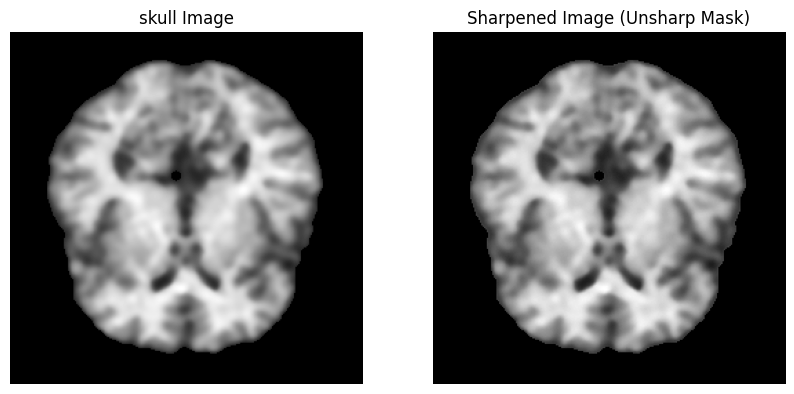

In [98]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Create the Gaussian blur of the original image
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Sharpen the image by subtracting the blurred version
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

# Apply Unsharp Masking to the image
enhanced = unsharp_mask(skull_stripped_image)

# Display both the enhanced and sharpened image side by side
plt.figure(figsize=(10, 5))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(skull_stripped_image, cmap='gray')
plt.title("skull Image")
plt.axis('off')

# Plot sharpened image
plt.subplot(1, 2, 2)
plt.imshow(sharpened_image, cmap='gray')
plt.title("Sharpened Image (Unsharp Mask)")
plt.axis('off')

plt.show()

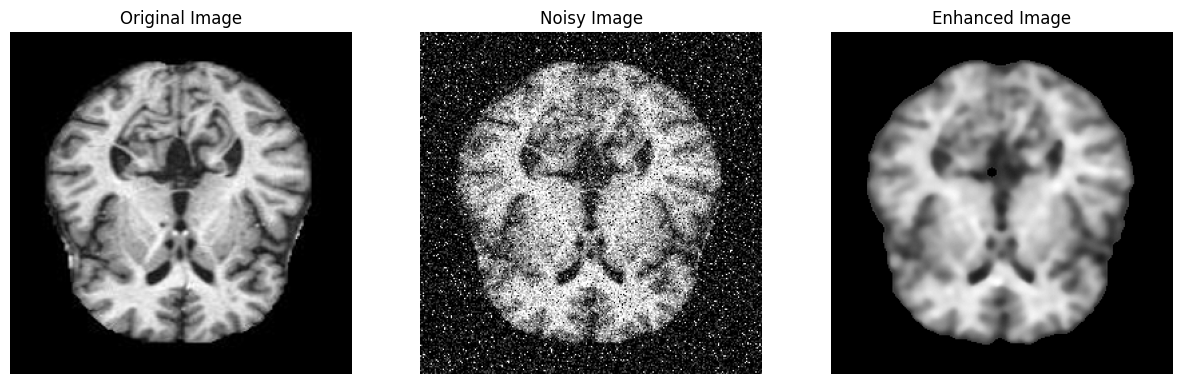

In [99]:
#compare between original vs noisy vs enhanced
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(images[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(salt_pepper_noisy__gaussian_images[0], cmap='gray')
plt.title("Noisy Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(enhanced, cmap='gray')
plt.title("Enhanced Image")
plt.axis('off')
plt.show()